In [1]:
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
pos_fraction = np.linspace(0.00, 1.00, 1000)

In [3]:
gini = 1 - pos_fraction**2 - (1-pos_fraction)**2

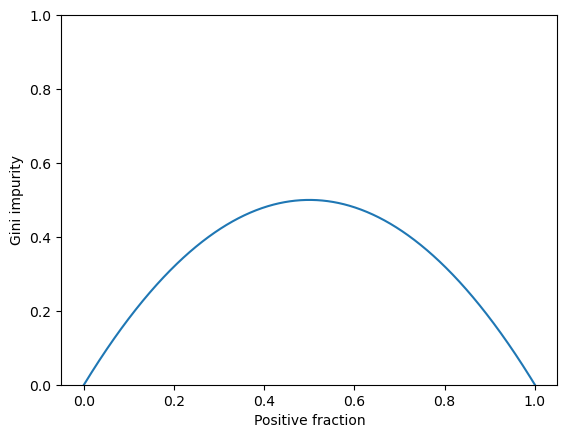

In [4]:
plt.plot(pos_fraction, gini) 
plt.ylim(0,1) 
plt.xlabel('Positive fraction') 
plt.ylabel('Gini impurity') 
plt.show() 

In [5]:
def gini_impurity(labels):
    # When the set is empty, it is also pure 
    if len(labels) == 0:
        return 0 
    # Count the occurrences of each_label 
    counts = np.unique(labels, return_counts=True)[1] 
    fractions = counts / float(len(labels)) 
    return 1 - np.sum(fractions**2)

In [6]:
print(f'{gini_impurity([1, 1, 0, 1, 0]):.4f}') 


0.4800


In [7]:
print(f'{gini_impurity([1, 1, 0, 1, 0, 0]):.4f}')

0.5000


In [8]:
print(f'{gini_impurity([1, 1, 1,]):.4f}')

0.0000


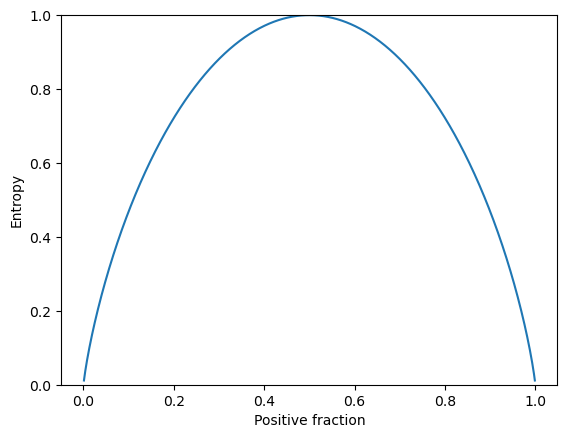

In [9]:
pos_fraction = np.linspace(0.001, 0.999, 1000) 
ent = - (pos_fraction  * np.log2(pos_fraction) + (1 - pos_fraction) * np.log2(1 - pos_fraction)) 
plt.plot(pos_fraction, ent) 
plt.xlabel('Positive fraction') 
plt.ylabel('Entropy') 
plt.ylim(0, 1) 
plt.show() 

In [10]:
def entropy(labels):
    if len(labels) == 0:
        return 0
    counts = np.unique(labels, return_counts=True)[1] 
    fractions = counts / float(len(labels)) 
    return - np.sum(fractions * np.log2(fractions)) 

In [11]:
print(f'{entropy([1, 1, 0, 1, 0]):.4f}') 


0.9710


In [12]:
print(f'{entropy([1, 1, 0, 1, 0, 0]):.4f}') 

1.0000


In [13]:
print(f'{entropy([1, 1, 1, 1]):.4f}')

-0.0000


In [14]:
criterion_function = {'gini': gini_impurity, 'entropy': entropy} 
def weighted_impurity(groups, criterion='gini'): 
    """ 
    Calculate weighted impurity of children after a split 
    @param groups: list of children, and a child consists a list of class labels 

    @param critierion: metric to measure the quality of a split, 
        'gini' for Gini impurity or 'entropy' for information gain  

    @return: float, weighted impurity
    """ 

    total = sum(len(group) for group in groups) 
    weighted_sum = 0.0
    for group in groups: 
        weighted_sum += len(group)/ float(total) * criterion_function[criterion](group) 
    return weighted_sum 
    

In [15]:
children_1 = [[1, 0, 1], [0, 1]] 
children_2 = [[1, 1], [0, 0, 1]] 
print(f"Entropy of #1 split: {weighted_impurity(children_1, 'entropy'):.4f}") 
        

Entropy of #1 split: 0.9510


In [16]:
print(f"Entropy of #2 split: {weighted_impurity(children_2, 'entropy'):.4f}")

Entropy of #2 split: 0.5510


In [17]:
def split_node(X, y, index, value): 
    X_index = X[:, index]
    # if this feature is numerical 
    if X[0, index].dtype.kind in ['i', 'f']:
        mask = X_index >= value 
    # if this feature is categorical 
    else: 
        mask = X_index == value 
    # split into left and right child 
    left = [X[~mask, :], y[~mask]] 
    right = [X[mask, :], y[mask]] 
    return left, right

In [18]:
def get_best_split(X, y, criterion):
    best_index, best_value, best_score, children = None, None, 1, None 

    for index in range(len(X[0])):
        for value in np.sort(np.unique(X[:, index])):
            groups = split_node(X, y, index, value)
            impurity = weighted_impurity(
                [groups[0][1], groups[1][1]], criterion)
            if impurity < best_score:
                best_index, best_value, best_score, children = index, value, impurity, groups
    return {'index': best_index, 'value': best_value, 'children': children}

In [19]:
def get_leaf(labels):
    # Obtain the leaf as the majority of the labels 
    return np.bincount(labels).argmax()

In [20]:
def split(node, max_depth, min_size, depth, criterion):
    left, right = (node['children'])
    if left[1].size == 0:
        node['right'] = get_leaf(right[1])
        return
    if right[1].size == 0:
        node['left'] = get_leaf(left[1])
        return 
    # Check if the current depth exceeds the maximal depth
    if depth >= max_depth:
        node['left'], node['right'] = get_leaf(left[1]), get_leaf(right[1]) 

        return 
    # Check if the left child has enough samples 
    if left[1].size <= min_size:
        node['left'] = get_leaf(left[1])
    else: 
        # It has enough samples, we further split it 
        result = get_best_split(left[0], left[1], criterion)
        result_left, result_right, = result['children'] 
        if result_left[1].size == 0: 
            node['left'] = get_leaf(result_right[1]) 
        elif result_right[1].size == 0:
            node['left'] = get_leaf(result_left[1])
        else: 
            node['left'] = result 
            split(node['left'], max_depth, min_size, depth + 1, criterion) 
            
    # Check if the right child has enough samples
    if right[1].size <= min_size:
        node['right'] = get_leaf(right[1])
    else: 
        # It has enough samples, we further split it 
        result = get_best_split(right[0], right[1], criterion) 
        result_left, result_right = result['children']  
        if result_left[1].size == 0:
            node['right'] = get_leaf(result_right[1])
        elif result_right[1].size == 0:
            node['right'] = get_leaf(result_left[1]) 
        else:
            node['right'] = result 
            split(node['right'], max_depth, min_size, depth + 1, criterion)
            
        
    
    

In [21]:
def train_tree(X_train, y_train, max_depth, min_size, criterion='gini'):
    X = np.array(X_train) 
    y = np.array(y_train) 
    root = get_best_split(X, y, criterion)
    split(root, max_depth, min_size, 1, criterion)
    return root

In [22]:
X_train = [['tech', 'professional'], ['fashion', 'student'], ['fashion', 'professional'],
           ['sports', 'student'], ['tech', 'student'], ['tech', 'retired'], ['sports', 'professional']]
y_train = [1, 0, 0, 0, 1, 0, 1] 
tree = train_tree(X_train, y_train, 2, 2)

In [23]:
CONDITION = {'numerical': {'yes': '>=', 'no': '<'},
             'categorical': {'yes': 'is', 'no': 'is not'}} 
def visualize_tree(node, depth=0):
    if isinstance(node, dict):
        if node['value'].dtype.kind in ['in', 'f']:
            condition = CONDITION['numerical'] 
        else: 
            condition = CONDITION['categorical']
        print('{}|-X{} {} {}'.format(depth * '  ', node['index'] + 1, condition['no'], node['value'])) 
        if 'left' in node: 
            visualize_tree(node['left'], depth + 1) 
        print('{}| -X{} {} {}'.format(depth * '  ' , node['index'] + 1, condition['yes'], node['value'])) 
        if 'right' in node: 
            visualize_tree(node['right'], depth + 1) 
    else: 
        print(f"{depth * '  '}[{node}]") 
visualize_tree(tree)


|-X1 is not fashion
  |-X2 is not professional
    [0]
  | -X2 is professional
    [1]
| -X1 is fashion
  [0]


In [24]:
X_train_n = [[6, 7], [2, 4], [7, 2],
             [3, 6], [4, 7], [5, 2],
             [1, 6], [2, 0], [6, 3],
             [4, 1]]
             

In [25]:
y_train_n = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
tree = train_tree(X_train_n, y_train_n, 2, 2)
visualize_tree(tree)

|-X2 is not 4
  |-X1 is not 7
    [1]
  | -X1 is 7
    [0]
| -X2 is 4
  |-X1 is not 2
    [1]
  | -X1 is 2
    [0]


In [26]:
## Implementing a Decision Tree with Scikit-learn

In [27]:
from sklearn.tree import DecisionTreeClassifier 
tree_sk = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_split=2) 
tree_sk.fit(X_train_n, y_train_n)

DecisionTreeClassifier(max_depth=2)

In [28]:
from sklearn.tree import export_graphviz 
export_graphviz(tree_sk, out_file='tree.dot', feature_names=['X1', 'X2'], impurity=False, filled=True, class_names=['0', '1'])

In [29]:
#dot -Tpng tree.dot -o tree.png

In [30]:
head train | sed 's/,,/, ,/g;s/,,/, ,/g' | column -s, -t

SyntaxError: invalid syntax (3327859881.py, line 1)

In [31]:
import pandas as pd 
n_rows = 300000
df = pd.read_csv("C:/Users/S/_devrepos/PyML_by_Example/data_for_PyML_by_Ex/ch3_datasets/train.csv", nrows=n_rows)

In [32]:
print(df.head(5))

             id  click      hour    C1  banner_pos   site_id site_domain  \
0  1.000009e+18      0  14102100  1005           0  1fbe01fe    f3845767   
1  1.000017e+19      0  14102100  1005           0  1fbe01fe    f3845767   
2  1.000037e+19      0  14102100  1005           0  1fbe01fe    f3845767   
3  1.000064e+19      0  14102100  1005           0  1fbe01fe    f3845767   
4  1.000068e+19      0  14102100  1005           1  fe8cc448    9166c161   

  site_category    app_id app_domain  ... device_type device_conn_type    C14  \
0      28905ebd  ecad2386   7801e8d9  ...           1                2  15706   
1      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
2      28905ebd  ecad2386   7801e8d9  ...           1                0  15704   
3      28905ebd  ecad2386   7801e8d9  ...           1                0  15706   
4      0569f928  ecad2386   7801e8d9  ...           1                0  18993   

   C15  C16   C17  C18  C19     C20  C21  
0  320   50  

In [33]:
Y = df['click'].values

In [34]:
X = df.drop(['click', 'id', 'hour', 'device_id', 'device_ip'], axis=1).values 
print(X.shape)

(300000, 19)


In [35]:
n_train = int(n_rows * 0.9) 
X_train = X[:n_train] 
Y_train = Y[:n_train] 
X_test =  X[n_train:]
Y_test =  Y[n_train:]

In [36]:
from sklearn.preprocessing import OneHotEncoder 
enc = OneHotEncoder(handle_unknown='ignore')

In [37]:
X_train_enc = enc.fit_transform(X_train) 
X_train_enc[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 19 stored elements and shape (1, 8204)>

In [38]:
print(X_train_enc[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 19 stored elements and shape (1, 8204)>
  Coords	Values
  (0, 2)	1.0
  (0, 6)	1.0
  (0, 188)	1.0
  (0, 2608)	1.0
  (0, 2679)	1.0
  (0, 3771)	1.0
  (0, 3885)	1.0
  (0, 3929)	1.0
  (0, 4879)	1.0
  (0, 7315)	1.0
  (0, 7319)	1.0
  (0, 7475)	1.0
  (0, 7824)	1.0
  (0, 7828)	1.0
  (0, 7869)	1.0
  (0, 7977)	1.0
  (0, 7982)	1.0
  (0, 8021)	1.0
  (0, 8189)	1.0


In [39]:
X_test_enc = enc.transform(X_test)

In [40]:
from sklearn.tree import DecisionTreeClassifier 
parameters = {'max_depth': [3, 10, None]}

In [41]:
decision_tree = DecisionTreeClassifier(criterion='gini', min_samples_split=30) 

In [42]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(decision_tree, parameters, n_jobs=-1, cv=3, scoring='roc_auc')

In [50]:
grid_search.fit(X_train_enc, Y_train)
print(grid_search.best_params_)


{'max_depth': None}


In [ ]:
decision_tree_best = grid_search.best_estimator_
pos_prob = decision_tree_best.predict_proba(X_test_enc)[:, 1]

In [60]:
from sklearn.metrics import roc_auc_score
print(f'The ROC AUC on testing set is: {roc_auc_score(Y_test, pos_prob):.3f}')

The ROC AUC on testing set is: 0.759


In [46]:
pos_prob = np.zeros(len(Y_test))

In [47]:
click_index = np.random.choice(len(Y_test),  int(len(Y_test) * 51211.0/300000),replace=False)
pos_prob[click_index]=1
print(f'The ROC AUC on testing set using random selection is: {roc_auc_score(Y_test, pos_prob):.3f}')

The ROC AUC on testing set using random selection is: 0.500


# Ensembling Decision Trees - Random Forests

In [57]:
from sklearn.ensemble import RandomForestClassifier 

In [58]:
random_forest = RandomForestClassifier(n_estimators=100, criterion='gini', min_samples_split=30, n_jobs=-1)
grid_search = GridSearchCV(random_forest, parameters, n_jobs=-1, cv=3, scoring='roc_auc')
grid_search.fit(X_train_enc, Y_train)
print(grid_search.best_params_)

{'max_depth': None}


In [61]:
random_forest_best = grid_search.best_estimator_
pos_prob = random_forest_best.predict_proba(X_test_enc)[:, 1]
print(f'The ROC AUC on testing set using random forest is: {roc_auc_score(Y_test, pos_prob):.3f}')

The ROC AUC on testing set using random forest is: 0.759


# Ensembling Decision Trees - Gradient-Boosted Trees

In [63]:
import xgboost as xgb 
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=1000)

In [65]:
model.fit(X_train_enc, Y_train)
pos_prob = model.predict_proba(X_test_enc)[:, 1]

In [66]:
print(f'The ROC AUC on testing set using GBT is: {roc_auc_score(Y_test, pos_prob):.3f}')

The ROC AUC on testing set using GBT is: 0.770
